In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward backward

In [3]:
S = 32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [4]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

### match directly

In [5]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [6]:
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)


In [7]:
# cuda kernel
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu, deltaDcsChunkArr_cu, deltaDcsVec_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [8]:
hs_cu2, n_cu2, m_cu2, matD_cu2 = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu2, dKs_cu2, dVs_cu2, dIgs_cu2, dFgs_cu2, matC_cu2, deltaDcsChunkArr_cu2, deltaDcsVec_cu2 = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu2,
    vec_m=m_cu2,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [9]:
dIgs_cu.dtype, dIgs_pt.dtype, dIgs_cu2.dtype

(torch.float32, torch.float32, torch.float32)

In [10]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}")

print(f"delta Q match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"delta K match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"delta V match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"delta Igate match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(mat_R_pt - matC_cu))}")

fw hs match: True, max diff: 5.7220458984375e-06
fw n match: True
fw m match: True
fw D match: True
delta Q match: True, max diff: 3.0517578125e-05
delta K match: True, max diff: 2.09808349609375e-05
delta V match: True, max diff: 9.5367431640625e-06
delta Igate match: True, max diff: 1.1920928955078125e-05
delta Fgate match: True, max diff: 5.125999450683594e-06
mat R match: True, max diff: 2.8014183044433594e-06


dKs diff:


(tensor([[[[ 1.1324e+00,  1.4895e+00,  4.3527e+00, -9.6225e-01, -8.0715e-01, -1.0221e+00, -8.7816e-01, -1.7540e+00],
           [ 1.0980e-01, -9.3231e-02,  4.0263e-02, -3.2514e-01,  7.8906e-03,  1.3242e-01, -7.0099e-03,  1.7658e-02],
           [ 8.4860e-02, -4.0262e-01, -7.7269e-01, -4.5987e-01,  2.4836e-01,  6.4835e-01, -3.0715e-02,  4.0553e-01],
           [-8.5479e-01, -4.4949e-01,  2.7011e-01, -7.5709e-01, -1.3189e+00, -6.7327e-01,  1.7258e+00,  2.2943e+00],
           [-3.0682e-01, -3.0234e-01, -6.6306e-01, -4.8825e-01, -3.3309e-01, -1.3588e-01,  5.3437e-01,  6.5328e-01],
           [-7.5008e-01, -2.0438e+00, -4.5130e+00, -3.2681e+00,  1.3968e+00, -4.9848e+00,  6.0342e+00,  2.2860e+00],
           [ 1.3208e-01,  5.5571e-01,  1.3982e-01,  1.1864e-01,  6.1045e-01, -8.8540e-01, -1.6289e-01,  8.0144e-01],
           [ 1.5922e+00,  6.0427e-01,  1.3527e+00,  3.8551e-01, -9.6351e-01, -6.4226e-01, -8.7630e-01,  1.7414e+00],
           [-1.3685e+00,  1.9551e-01, -5.8941e-01, -1.1542e+00, 

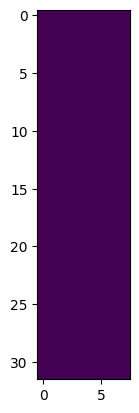

In [11]:
print(f"dKs diff:")
fig = plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

dVs diff:


(tensor([[[[ 1.0873e+00, -4.4179e-01,  4.6924e-01, -2.9992e-01,  4.2231e-01, -1.8083e+00,  7.0483e-03,  6.6160e-02],
           [-4.2192e-02,  1.5613e-01,  6.0105e-02,  2.9632e-01, -7.3016e-02, -1.0028e-01, -5.3693e-02, -4.4049e-02],
           [ 3.1096e-01, -1.0333e+00,  1.3538e-01, -1.3126e+00,  8.3544e-02, -2.4328e-01,  1.6255e-01,  4.9550e-01],
           [ 2.8298e+00, -1.2045e+00,  8.4240e-01, -1.4697e+00,  7.0276e-01,  4.9789e-01,  4.3443e-01, -1.5615e+00],
           [ 3.2599e-01, -2.8339e-02,  7.8918e-01,  2.0709e-01,  5.2847e-02, -1.5167e-01,  1.4606e-01,  4.8626e-01],
           [-9.8748e-03,  1.3905e+00,  1.0319e+00,  7.2394e-01,  1.3034e+00,  7.9472e-01, -2.0517e-01, -3.9097e-01],
           [ 5.6656e-01, -8.0302e-01, -4.1675e-01,  2.1926e+00, -1.2227e-01, -1.6997e+00,  8.0959e-01, -1.2534e+00],
           [-2.7562e-01,  2.7621e-01,  5.1619e-01,  1.8641e+00,  1.4623e+00,  7.7299e-02, -3.6621e-01,  3.4077e-01],
           [ 1.1211e-01, -3.9189e-01,  6.9862e-01, -7.3238e-01, 

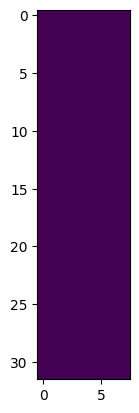

In [12]:
print(f"dVs diff:")
fig = plt.imshow(((dVs_cu - dVs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dVs_cu, dVs_pt, (dVs_cu - dVs_pt).abs() < BW_ATOL

fw hs match: True, max diff: 5.7220458984375e-06
fw n match: True, max diff: 7.152557373046875e-06
fw m match: True, max diff: 3.6954879760742188e-06
fw D match: True, max diff: 5.245208740234375e-06
delta Q match: True, max diff: 3.0517578125e-05
delta K match: True, max diff: 2.09808349609375e-05
delta V match: True, max diff: 9.5367431640625e-06
delta Igate match: True, max diff: 1.1920928955078125e-05
delta Fgate match: True, max diff: 5.125999450683594e-06
mat R match: True, max diff: 2.8014183044433594e-06


(tensor([[[[ 1.1324e+00,  1.4895e+00,  4.3527e+00, -9.6225e-01, -8.0715e-01, -1.0221e+00, -8.7816e-01, -1.7540e+00],
           [ 1.0980e-01, -9.3231e-02,  4.0263e-02, -3.2514e-01,  7.8906e-03,  1.3242e-01, -7.0099e-03,  1.7658e-02],
           [ 8.4860e-02, -4.0262e-01, -7.7269e-01, -4.5987e-01,  2.4836e-01,  6.4835e-01, -3.0715e-02,  4.0553e-01],
           [-8.5479e-01, -4.4949e-01,  2.7011e-01, -7.5709e-01, -1.3189e+00, -6.7327e-01,  1.7258e+00,  2.2943e+00],
           [-3.0682e-01, -3.0234e-01, -6.6306e-01, -4.8825e-01, -3.3309e-01, -1.3588e-01,  5.3437e-01,  6.5328e-01],
           [-7.5008e-01, -2.0438e+00, -4.5130e+00, -3.2681e+00,  1.3968e+00, -4.9848e+00,  6.0342e+00,  2.2860e+00],
           [ 1.3208e-01,  5.5571e-01,  1.3982e-01,  1.1864e-01,  6.1045e-01, -8.8540e-01, -1.6289e-01,  8.0144e-01],
           [ 1.5922e+00,  6.0427e-01,  1.3527e+00,  3.8551e-01, -9.6351e-01, -6.4226e-01, -8.7630e-01,  1.7414e+00],
           [-1.3685e+00,  1.9551e-01, -5.8941e-01, -1.1542e+00, 

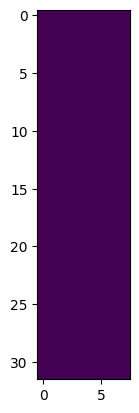

In [13]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"fw hs match: {torch.allclose(hs_cu2, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.abs(hs_cu2 - hs_pt).max()}")
print(f"fw n match: {torch.allclose(n_cu2, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.abs(n_cu2 - n_pt).max()}")
print(f"fw m match: {torch.allclose(m_cu2, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.abs(m_cu2 - m_pt).max()}")
print(f"fw D match: {torch.allclose((matD_cu2 - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.abs((matD_cu2 - matD_pt).tril()).max()}")

print(f"delta Q match: {torch.allclose(dQs_cu2, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(dQs_cu2 - dQs_pt).max()}")
print(f"delta K match: {torch.allclose(dKs_cu2, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(dKs_cu2 - dKs_pt).max()}")
print(f"delta V match: {torch.allclose(dVs_cu2, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(dVs_cu2 - dVs_pt).max()}")
print(f"delta Igate match: {torch.allclose(dIgs_cu2, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(dIgs_cu2 - dIgs_pt).max()}")
print(f"delta Fgate match: {torch.allclose(dFgs_cu2, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(dFgs_cu2 - dFgs_pt).max()}")

print(f"mat R match: {torch.allclose(mat_R_pt, matC_cu2, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.abs(mat_R_pt - matC_cu2).max()}")
plt.imshow(((dKs_cu - dKs_pt).abs() < BW_ATOL).squeeze().cpu().numpy())
dKs_cu, dKs_pt, (dKs_cu - dKs_pt).abs() < BW_ATOL

In [14]:
dKs_cu, dKs_cu2, dKs_pt

(tensor([[[[ 1.1324e+00,  1.4895e+00,  4.3527e+00, -9.6225e-01, -8.0715e-01, -1.0221e+00, -8.7816e-01, -1.7540e+00],
           [ 1.0980e-01, -9.3231e-02,  4.0263e-02, -3.2514e-01,  7.8906e-03,  1.3242e-01, -7.0099e-03,  1.7658e-02],
           [ 8.4860e-02, -4.0262e-01, -7.7269e-01, -4.5987e-01,  2.4836e-01,  6.4835e-01, -3.0715e-02,  4.0553e-01],
           [-8.5479e-01, -4.4949e-01,  2.7011e-01, -7.5709e-01, -1.3189e+00, -6.7327e-01,  1.7258e+00,  2.2943e+00],
           [-3.0682e-01, -3.0234e-01, -6.6306e-01, -4.8825e-01, -3.3309e-01, -1.3588e-01,  5.3437e-01,  6.5328e-01],
           [-7.5008e-01, -2.0438e+00, -4.5130e+00, -3.2681e+00,  1.3968e+00, -4.9848e+00,  6.0342e+00,  2.2860e+00],
           [ 1.3208e-01,  5.5571e-01,  1.3982e-01,  1.1864e-01,  6.1045e-01, -8.8540e-01, -1.6289e-01,  8.0144e-01],
           [ 1.5922e+00,  6.0427e-01,  1.3527e+00,  3.8551e-01, -9.6351e-01, -6.4226e-01, -8.7630e-01,  1.7414e+00],
           [-1.3685e+00,  1.9551e-01, -5.8941e-01, -1.1542e+00, 

In [15]:
from kernel_call_checks.multicall_fwbw import check_multi_kernel_calls_fwbw, check_multi_kernel_calls_fw

In [16]:
N = 100
check_multi_kernel_calls_fw(q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

100%|██████████| 100/100 [00:00<00:00, 1411.08it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S

In [17]:
N = 100
check_multi_kernel_calls_fwbw(dH=dHs,q=qs, k=ks, v=vs, ig=igs, fg=fgs, num_calls=N, atol=FW_ATOL, rtol=FW_RTOL)

 75%|███████▌  | 75/100 [00:00<00:00, 745.96it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S

100%|██████████| 100/100 [00:00<00:00, 699.91it/s]

before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 32, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S